In [33]:
# -*- coding: utf-8 -*-
"""
Created on Thu May 24 13:32:33 2018

@author: cheng-man wu

LinkedIn: www.linkedin.com/in/chengmanwu
Github: https://github.com/wurmen
"""
'''==========Solving job shop scheduling problem by NSGA-II algorithm in python======='''
# importing required modules
#import os
import pandas as pd
import numpy as np
import time
import copy
''' ================= initialization setting ======================'''
num_job=10 # number of jobs
num_mc=10 # number of machines

pt_tmp=pd.read_excel("JSP_dataset.xlsx",sheet_name="Processing Time",index_col =[0])
ms_tmp=pd.read_excel("JSP_dataset.xlsx",sheet_name="Machines Sequence",index_col =[0])
job_priority_duedate_tmp=pd.read_excel("JSP_dataset.xlsx",sheet_name="Priority and Due date",index_col =[0])

# raw_input is used in python 2
population_size=int(input('Please input the size of population: ') or 20) # default value is 20
crossover_rate=float(input('Please input the size of Crossover Rate: ') or 0.8) # default value is 0.8
mutation_rate=float(input('Please input the size of Mutation Rate: ') or 0.3) # default value is 0.3
mutation_selection_rate=float(input('Please input the mutation selection rate: ') or 0.4)
num_mutation_jobs=round(num_job*num_mc*mutation_selection_rate)
num_iteration=int(input('Please input number of iteration: ') or 1000) # default value is 1000

# speed up the data search
# Below code can also be  written "pt = pt_tmp.as_matrix().tolist()"
pt=[list(map(int, pt_tmp.iloc[i])) for i in range(num_job)]
ms=[list(map(int,ms_tmp.iloc[i])) for i in range(num_job)]
job_priority_duedate=[list(job_priority_duedate_tmp.iloc[i]) for i in range(num_job)]
start_time = time.time()
'''===========function==============='''
'''-------non-dominated sorting function-------'''      
def non_dominated_sorting(population_size,chroms_obj_record):
    s,n={},{}
    front,rank={},{}
    front[0]=[]     
    for p in range(population_size*2):
        s[p]=[]
        n[p]=0
        for q in range(population_size*2):
            
            if ((chroms_obj_record[p][0]<chroms_obj_record[q][0] and chroms_obj_record[p][1]<chroms_obj_record[q][1]) or (chroms_obj_record[p][0]<=chroms_obj_record[q][0] and chroms_obj_record[p][1]<chroms_obj_record[q][1])
            or (chroms_obj_record[p][0]<chroms_obj_record[q][0] and chroms_obj_record[p][1]<=chroms_obj_record[q][1])):
                if q not in s[p]:
                    s[p].append(q)
            elif ((chroms_obj_record[p][0]>chroms_obj_record[q][0] and chroms_obj_record[p][1]>chroms_obj_record[q][1]) or (chroms_obj_record[p][0]>=chroms_obj_record[q][0] and chroms_obj_record[p][1]>chroms_obj_record[q][1])
            or (chroms_obj_record[p][0]>chroms_obj_record[q][0] and chroms_obj_record[p][1]>=chroms_obj_record[q][1])):
                n[p]=n[p]+1
        if n[p]==0:
            rank[p]=0
            if p not in front[0]:
                front[0].append(p)
    
    i=0
    while (front[i]!=[]):
        Q=[]
        for p in front[i]:
            for q in s[p]:
                n[q]=n[q]-1
                if n[q]==0:
                    rank[q]=i+1
                    if q not in Q:
                        Q.append(q)
        i=i+1
        front[i]=Q
                
    del front[len(front)-1]
    return front

'''--------calculate crowding distance function---------'''
def calculate_crowding_distance(front,chroms_obj_record):
    
    distance={m:0 for m in front}
    for o in range(2):
        obj={m:chroms_obj_record[m][o] for m in front}
        sorted_keys=sorted(obj, key=obj.get)
        distance[sorted_keys[0]]=distance[sorted_keys[len(front)-1]]=999999999999
        for i in range(1,len(front)-1):
            if len(set(obj.values()))==1:
                distance[sorted_keys[i]]=distance[sorted_keys[i]]
            else:
                distance[sorted_keys[i]]=distance[sorted_keys[i]]+(obj[sorted_keys[i+1]]-obj[sorted_keys[i-1]])/(obj[sorted_keys[len(front)-1]]-obj[sorted_keys[0]])
            
    return distance            
'''----------selection----------'''
def selection(population_size,front,chroms_obj_record,total_chromosome):   
    N=0
    new_pop=[]
    while N < population_size:
        for i in range(len(front)):
            N=N+len(front[i])
            if N > population_size:
                distance=calculate_crowding_distance(front[i],chroms_obj_record)
                sorted_cdf=sorted(distance, key=distance.get)
                sorted_cdf.reverse()
                for j in sorted_cdf:
                    if len(new_pop)==population_size:
                        break                
                    new_pop.append(j)              
                break
            else:
                new_pop.extend(front[i])
    
    population_list=[]
    for n in new_pop:
        population_list.append(total_chromosome[n])
    
    return population_list,new_pop


'''==================== main code ==============================='''
'''----- generate initial population -----'''
best_list,best_obj=[],[]
population_list=[]
for i in range(population_size):
    nxm_random_num=list(np.random.permutation(num_job*num_mc)) # generate a random permutation of 0 to num_job*num_mc-1
    population_list.append(nxm_random_num) # add to the population_list
    for j in range(num_job*num_mc):
        population_list[i][j]=population_list[i][j]%num_job # convert to job number format, every job appears m times
        
for n in range(num_iteration):           
    '''-------- two point crossover --------'''
    parent_list=copy.deepcopy(population_list)
    offspring_list=[]
    S=list(np.random.permutation(population_size)) # generate a random sequence to select the parent chromosome to crossover
    
    for m in range(int(population_size/2)):
        
        parent_1= population_list[S[2*m]][:]
        parent_2= population_list[S[2*m+1]][:]
        child_1=parent_1[:]
        child_2=parent_2[:]
        
        cutpoint=list(np.random.choice(num_job*num_mc, 2, replace=False))
        cutpoint.sort()
    
        child_1[cutpoint[0]:cutpoint[1]]=parent_2[cutpoint[0]:cutpoint[1]]
        child_2[cutpoint[0]:cutpoint[1]]=parent_1[cutpoint[0]:cutpoint[1]]
        
        offspring_list.extend((child_1,child_2)) # append child chromosome to offspring list
    '''----------repairment-------------'''
    for m in range(population_size):
        job_count={}
        larger,less=[],[] # 'larger' record jobs appear in the chromosome more than m times, and 'less' records less than m times.
        for i in range(num_job):
            if i in offspring_list[m]:
                count=offspring_list[m].count(i)
                pos=offspring_list[m].index(i)
                job_count[i]=[count,pos] # store the above two values to the job_count dictionary
            else:
                count=0
                job_count[i]=[count,0]
            if count>num_mc:
                larger.append(i)
            elif count<num_mc:
                less.append(i)
                
        for k in range(len(larger)):
            chg_job=larger[k]
            while job_count[chg_job][0]>num_mc:
                for d in range(len(less)):
                    if job_count[less[d]][0]<num_mc:                    
                        offspring_list[m][job_count[chg_job][1]]=less[d]
                        job_count[chg_job][1]=offspring_list[m].index(chg_job)
                        job_count[chg_job][0]=job_count[chg_job][0]-1
                        job_count[less[d]][0]=job_count[less[d]][0]+1                    
                    if job_count[chg_job][0]==num_mc:
                        break        
    
    '''--------mutatuon--------'''   
    for m in range(len(offspring_list)):
        mutation_prob=np.random.rand()
        if mutation_rate <= mutation_prob:
            m_chg=list(np.random.choice(num_job*num_mc, num_mutation_jobs, replace=False)) # chooses the position to mutation
            t_value_last=offspring_list[m][m_chg[0]] # save the value which is on the first mutation position
            for i in range(num_mutation_jobs-1):
                offspring_list[m][m_chg[i]]=offspring_list[m][m_chg[i+1]] # displacement
            
            offspring_list[m][m_chg[num_mutation_jobs-1]]=t_value_last # move the value of the first mutation position to the last mutation position   
                        
    
    '''--------fitness value(calculate idle time)-------------'''
    num_m = 10
    chrom_fitness,chrom_fit=[],[]
    total_fitness=0
    s,d,D={},{},{}
    v=[0 for c in range(population_size*2)]
    '''--------fitness value(calculate  makespan and TWET)-------------'''
    total_chromosome=copy.deepcopy(parent_list)+copy.deepcopy(offspring_list) # combine parent and offspring chromosomes
    chroms_obj_record={} # record each chromosome objective values as chromosome_obj_record={chromosome:[TWET,makespan]}
    for m in range(population_size*2):
        j_keys=[j for j in range(num_job)]
        key_count={key:0 for key in j_keys}
        j_count={key:0 for key in j_keys}
        m_keys=[j+1 for j in range(num_mc)]
        m_count={key:0 for key in m_keys}
        d_record={} # record jobs earliness and tardiness time as d_record={job:[earliness time,tardiness time]}
        
        c = m
    
        for i in range(num_m):
            s[c,i]=pt[total_chromosome[c][0]][i]
            d[c,i]=v[c]
            D[c,i,total_chromosome[c][0]]=v[c]
            v[c]=v[c]+pt[total_chromosome[c][0]][i]

        for j in range(num_job):
            D[c,0,j]=0

        for j in range(1,num_job):
            for i in range(0,num_m-1):
                s[c,i]=s[c,i]+pt[total_chromosome[c][j]][i]
                D[c,i+1,j]=max(0,s[c,i]+d[c,i]-s[c,i+1]-d[c,i+1])
                d[c,i+1]=d[c,i+1]+D[c,i+1,j]

            s[c,num_m-1]=s[c,num_m-1]+pt[total_chromosome[c][j]][i+1]

        v[c]=0
        for i in range(num_m):
            v[c]=v[c]+d[c,i]
        OEE = (makespan * 10 - v[c]) / (makespan * 10)
        OEE_scaled = OEE * (makespan * 10)

        chrom_fitness.append(1/v[c])
        chrom_fit.append(v[c])
        total_fitness=total_fitness+chrom_fitness[c]

        
        for i in total_chromosome[m]:
            gen_t=int(pt[i][key_count[i]])
            gen_m=int(ms[i][key_count[i]])
            j_count[i]=j_count[i]+gen_t
            m_count[gen_m]=m_count[gen_m]+gen_t
            
            if m_count[gen_m]<j_count[i]:
                m_count[gen_m]=j_count[i]
            elif m_count[gen_m]>j_count[i]:
                j_count[i]=m_count[gen_m]
            
            key_count[i]=key_count[i]+1
    
        for j in j_keys:
            if j_count[j]>job_priority_duedate[j][1]:
                job_tardiness=j_count[j]-job_priority_duedate[j][1]
                job_earliness=0
                d_record[j]=[job_earliness,job_tardiness]
            elif j_count[j]<job_priority_duedate[j][1]:
                job_tardiness=0
                job_earliness=job_priority_duedate[j][1]-j_count[j]
                d_record[j]=[job_earliness,job_tardiness]
            else:
                job_tardiness=0
                job_earliness=0
                d_record[j]=[job_earliness,job_tardiness]
        
        twet=sum((1/job_priority_duedate[j][0])*d_record[j][0]+job_priority_duedate[j][0]*d_record[j][1] for j in j_keys)
        makespan=max(j_count.values())
        # chroms_obj_record[m]=[twet,makespan]
        # chroms_obj_record[m]=[v[c],makespan]
        # chroms_obj_record[m]=[OEE,makespan]
        # chroms_obj_record[m]=[OEE_scaled,makespan]
        chroms_obj_record[m]=[OEE * 100,makespan]
                       
    
    '''-------non-dominated sorting-------'''      
    front=non_dominated_sorting(population_size,chroms_obj_record)
        
    '''----------selection----------'''
    population_list,new_pop=selection(population_size,front,chroms_obj_record,total_chromosome)
    new_pop_obj=[chroms_obj_record[k] for k in new_pop]    
    

    '''----------comparison----------'''
    if n==0:
        best_list=copy.deepcopy(population_list)
        best_obj=copy.deepcopy(new_pop_obj)
    else:            
        total_list=copy.deepcopy(population_list)+copy.deepcopy(best_list)
        total_obj=copy.deepcopy(new_pop_obj)+copy.deepcopy(best_obj)
        
        now_best_front=non_dominated_sorting(population_size,total_obj)
        best_list,best_pop=selection(population_size,now_best_front,total_obj,total_list)
        best_obj=[total_obj[k] for k in best_pop]
'''----------result----------'''
print(best_list)
print(best_obj)
print('the elapsed time:%s'% (time.time() - start_time))




Please input the size of population:  
Please input the size of Crossover Rate:  
Please input the size of Mutation Rate:  
Please input the mutation selection rate:  
Please input number of iteration:  


[[1, 5, 3, 8, 6, 8, 3, 6, 8, 0, 0, 7, 4, 3, 8, 5, 5, 0, 7, 3, 4, 9, 1, 0, 3, 0, 9, 9, 6, 9, 8, 0, 3, 5, 6, 9, 7, 1, 7, 3, 4, 0, 7, 8, 5, 4, 1, 2, 5, 8, 4, 0, 9, 0, 6, 2, 2, 4, 4, 9, 6, 2, 7, 5, 1, 7, 1, 9, 8, 7, 2, 6, 5, 5, 4, 3, 1, 7, 6, 4, 2, 2, 5, 1, 2, 8, 1, 0, 4, 2, 6, 9, 3, 8, 3, 7, 6, 9, 1, 2], [5, 1, 3, 8, 6, 8, 3, 6, 8, 0, 0, 7, 4, 3, 8, 5, 5, 0, 7, 3, 4, 9, 1, 0, 3, 0, 9, 9, 6, 9, 8, 0, 3, 5, 6, 9, 7, 1, 2, 3, 4, 0, 7, 8, 5, 4, 1, 2, 5, 8, 4, 0, 9, 0, 6, 2, 7, 4, 4, 9, 6, 2, 7, 5, 1, 7, 1, 9, 8, 7, 2, 6, 5, 5, 4, 3, 1, 7, 6, 4, 2, 2, 5, 1, 2, 8, 1, 0, 4, 2, 6, 9, 3, 8, 3, 7, 6, 9, 1, 2], [5, 2, 7, 1, 1, 1, 3, 3, 3, 5, 4, 3, 4, 3, 8, 2, 5, 1, 7, 3, 1, 0, 4, 8, 3, 7, 6, 1, 7, 9, 8, 0, 3, 5, 6, 9, 7, 1, 3, 0, 6, 8, 7, 8, 5, 6, 0, 7, 5, 8, 5, 0, 1, 0, 2, 2, 6, 2, 4, 4, 9, 9, 9, 4, 4, 9, 2, 4, 8, 7, 2, 2, 6, 0, 6, 2, 1, 9, 8, 6, 3, 9, 5, 1, 5, 0, 6, 9, 0, 2, 8, 8, 4, 9, 6, 7, 4, 7, 5, 0], [5, 2, 7, 1, 1, 1, 3, 3, 3, 5, 4, 3, 4, 3, 8, 2, 5, 1, 7, 3, 1, 0, 4, 8, 3, 7, 6, 1, 7, 9, 8,

### 取第一個解來畫排程甘特圖

In [34]:
'''--------plot gantt chart-------'''
import pandas as pd
# import plotly.plotly as py
import plotly.figure_factory as ff
import datetime
import chart_studio.plotly as py

m_keys=[j+1 for j in range(num_mc)]
j_keys=[j for j in range(num_job)]
key_count={key:0 for key in j_keys}
j_count={key:0 for key in j_keys}
m_count={key:0 for key in m_keys}
j_record={}
for i in best_list[0]:
    gen_t=int(pt[i][key_count[i]])
    gen_m=int(ms[i][key_count[i]])
    j_count[i]=j_count[i]+gen_t
    m_count[gen_m]=m_count[gen_m]+gen_t
    
    if m_count[gen_m]<j_count[i]:
        m_count[gen_m]=j_count[i]
    elif m_count[gen_m]>j_count[i]:
        j_count[i]=m_count[gen_m]
    
    start=j_count[i]-pt[i][key_count[i]]
    start_time=str(datetime.timedelta(seconds=start)) # convert seconds to hours, minutes and seconds
    end_time=str(datetime.timedelta(seconds=j_count[i]))  
    j_record[(i,gen_m)]=[start_time,end_time]
    
    key_count[i]=key_count[i]+1
        

df=[]
for m in m_keys:
    for j in j_keys:
        df.append(dict(Task='Machine %s'%(m), Start='2018-07-14 %s'%(str(j_record[(j,m)][0])), Finish='2018-07-14 %s'%(str(j_record[(j,m)][1])),Resource='Job %s'%(j+1)))
    
fig = ff.create_gantt(df, index_col='Resource', show_colorbar=True, group_tasks=True, showgrid_x=True, title='Job shop Schedule')
# py.iplot(fig, filename='GA_job_shop_scheduling1', world_readable=True)

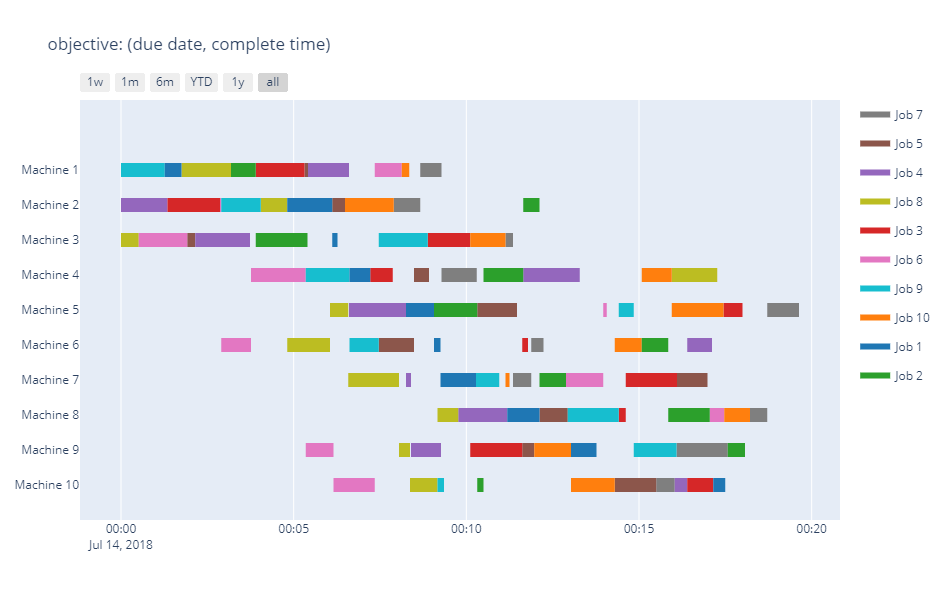

In [32]:
fig.update_layout(
    title = "objective: (due date, complete time)"
)
fig.show()

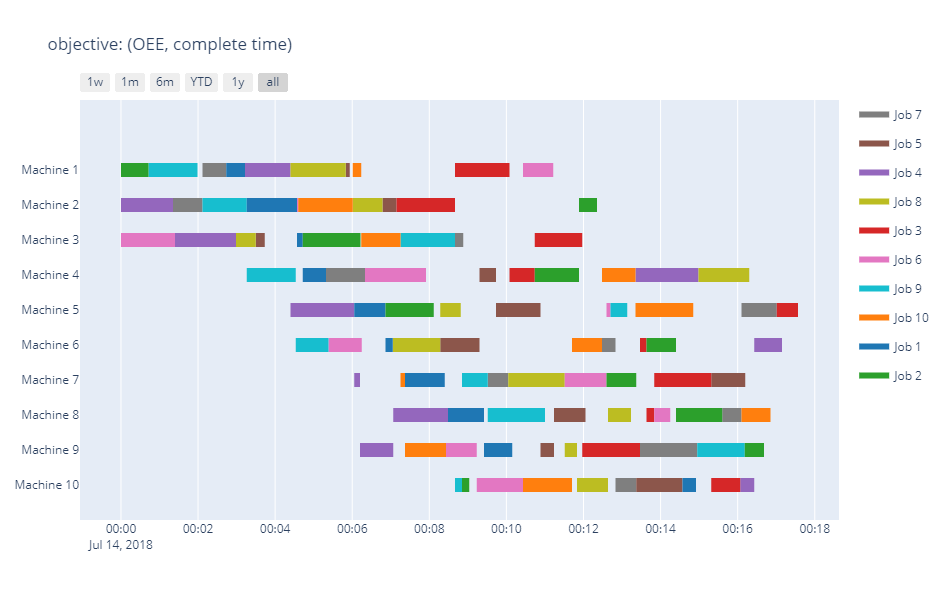

In [37]:
fig.update_layout(
    title = "objective: (OEE, complete time)"
)
fig.show()